## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import pickle
import gseapy as gp
import anndata as ad

from gseapy import dotplot
from scipy.stats import hypergeom
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## Loading Data

In [2]:
with open('Model/model_genes.pkl', 'rb') as f:
    sc_genes = pickle.load(f)
            
with open('Model/model_yng.pkl', 'rb') as f:
    yng = pd.DataFrame(
        pickle.load(f).todense(),
        index = [0] * 400,
        columns = sc_genes
    )
    
with open('Model/model_old.pkl', 'rb') as f:
    old = pd.DataFrame(
        pickle.load(f).todense(),
        index = [1] * 400,
        columns = sc_genes
    )

yng = ad.AnnData(yng)
old = ad.AnnData(old)

sc.pp.normalize_total(yng, exclude_highly_expressed = True)
sc.pp.normalize_total(old, exclude_highly_expressed = True)
sc.pp.log1p(yng)
sc.pp.log1p(old)

yng = yng.to_df().astype(float)
old = old.to_df().astype(float)

adata = sq.read.visium('GanierDatasets/WSSKNKCLsp10446618', counts_file = 'filtered_feature_bc_matrix.h5')
vis_genes = adata.var.index
del adata

C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\s4637482\AppData\Local\anac

## Building Model & Checking Feature Importance

In [3]:
common_genes = vis_genes.intersection(yng.columns)
yng = yng[common_genes]
old = old[common_genes]

yng_trn, yng_tst = train_test_split(yng, test_size = 0.1, random_state = 42)
old_trn, old_tst = train_test_split(old, test_size = 0.1, random_state = 42)
trn_X = pd.concat([yng_trn, old_trn], axis = 0)
tst_X = pd.concat([yng_tst, old_tst], axis = 0)

scaler = StandardScaler()
scale = lambda x : pd.DataFrame(scaler.fit_transform(x), index = x.index, columns = x.columns)

scld_trn_X = scale(trn_X)
scld_tst_X = scale(tst_X)

trn_y = trn_X.index
tst_y = tst_X.index

In [4]:
clf = RandomForestClassifier(
    n_estimators = 500,
    max_features = 148,
    max_depth = 11,
    min_samples_split = 2,
    min_samples_leaf = 1,
    criterion = 'gini',
    ccp_alpha = 0.0,
    max_samples = 1.0,
    random_state = 42,
    n_jobs = 8
)
clf.fit(trn_X, trn_y)

RandomForestClassifier(max_depth=11, max_features=148, max_samples=1.0,
                       n_estimators=500, n_jobs=8, random_state=42)

In [5]:
feature_importances = pd.Series(
    clf.feature_importances_,
    index = yng.columns
)
feature_importances = pd.concat([feature_importances, (old_trn.mean() - yng_trn.mean()) > 0], axis = 1)
feature_importances.columns = ['importance', 'upregulated']
feature_importances = feature_importances.sort_values('importance', ascending = False)
feature_importances.reset_index(inplace = True, names = 'gene')
feature_importances

,gene,importance,upregulated
0,MRC2,0.020329,True
1,COL6A1,0.019216,True
2,FBLN1,0.018641,True
3,USP53,0.015472,True
4,RPL5,0.014530,True
...,...,...,...
14584,GPR183,0.000000,False
14585,GPR18,0.000000,False
14586,ARHGAP26-IT1,0.000000,True
14587,UBAC2-AS1,0.000000,False


In [6]:
feature_importances.head(10)

,gene,importance,upregulated
0,MRC2,0.020329,True
1,COL6A1,0.019216,True
2,FBLN1,0.018641,True
3,USP53,0.015472,True
4,RPL5,0.014530,True
5,RPL4,0.014017,True
6,DCN,0.013848,True
7,VIM,0.013001,True
8,FN1,0.011931,True
9,RPS8,0.011077,False


In [7]:
feature_importances.to_csv('feature_importances.csv')

In [8]:
20 * (1 / yng.shape[1])

0.0013708958804578791

## Upregulated Features

In [9]:
up_genes = list((feature_importances[(feature_importances['importance'] > 20 * (1 / yng.shape[1])) & (feature_importances['upregulated'])])['gene'])

In [10]:
up_genes = list((feature_importances[(feature_importances['importance'] > 10 * (1 / yng.shape[1])) & (feature_importances['upregulated'])])['gene'])

In [11]:
len(up_genes)

196

In [12]:
'MIF' in up_genes

False

In [13]:
enr = gp.enrichr(
    gene_list = up_genes,
    gene_sets = ['MSigDB_Hallmark_2020', 'KEGG_2021_Human'],
    organism = 'human',
    outdir = None
)

In [14]:
pd.set_option('display.max_rows', None)

enr.results[enr.results['Adjusted P-value'] < 0.05]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,35/200,7.648893e-34,3.212535e-32,0,0,25.874835,1973.042412,FBN2;SPARC;LRP1;SERPINE2;TNFRSF11B;FBLN1;LAMC1...
1,MSigDB_Hallmark_2020,Coagulation,14/138,8.598644e-11,1.805715e-09,0,0,12.208437,282.952881,SPARC;C1S;LRP1;C1R;FN1;PLAT;CLU;PRSS23;THBS1;C...
2,MSigDB_Hallmark_2020,Complement,13/200,9.197331e-08,1.287626e-06,0,0,7.452178,120.738463,CEBPB;LRP1;HSPA5;C1S;C1R;ANXA5;FN1;PLAT;CLU;C3...
3,MSigDB_Hallmark_2020,Apoptosis,11/161,5.603658e-07,5.883841e-06,0,0,7.790775,112.145679,PDGFRB;CCND1;GPX4;LUM;LMNA;TIMP2;TIMP3;PLAT;IG...
4,MSigDB_Hallmark_2020,Unfolded Protein Response,7/113,1.254130e-04,9.798925e-04,0,0,6.882600,61.832573,CEBPB;HSPA5;XPOT;KIF5B;CCL2;EEF2;SEC31A
5,MSigDB_Hallmark_2020,Hypoxia,9/200,1.633154e-04,9.798925e-04,0,0,4.942100,43.094261,LDHA;COL5A1;LOX;HSPA5;IGFBP3;HDLBP;S100A4;TGFB...
6,MSigDB_Hallmark_2020,Myogenesis,9/200,1.633154e-04,9.798925e-04,0,0,4.942100,43.094261,COL1A1;SPARC;IGFBP3;COL6A2;PDE4DIP;IGFBP7;AEBP...
7,MSigDB_Hallmark_2020,Myc Targets V1,8/200,8.195456e-04,4.302615e-03,0,0,4.346631,30.890467,LDHA;SLC25A3;HSP90AB1;XPOT;HNRNPA2B1;HNRNPU;RP...
8,MSigDB_Hallmark_2020,Apical Junction,7/200,3.642169e-03,1.529711e-02,0,0,3.763385,21.132069,ARPC2;CDH11;TNFRSF11B;TGFBI;MYL9;VCL;MYL12B
9,MSigDB_Hallmark_2020,Glycolysis,7/200,3.642169e-03,1.529711e-02,0,0,3.763385,21.132069,LDHA;COL5A1;HSPA5;IGFBP3;HDLBP;TGFBI;DCN


C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
C:\Users\s4637482\AppData\Local\anaconda3\envs\bioinf_env\Lib\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


<Axes: title={'center': 'Important upregulated model genes'}, xlabel='Combined Score'>

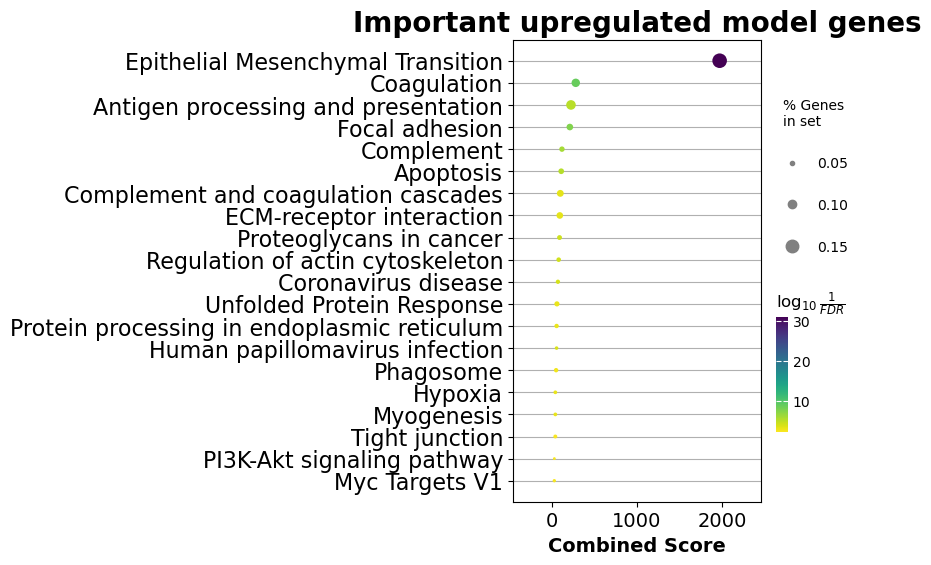

In [15]:
dotplot(enr.results, column = 'Adjusted P-value', size = 10, title = 'Important upregulated model genes', top_term = 20)

## Downregulated Features

In [16]:
down_genes = list(feature_importances[(feature_importances['importance'] >  10 * (1 / yng.shape[1])) & ~(feature_importances['upregulated'])].sort_values('importance', ascending = False)['gene'])

In [17]:
len(down_genes)

12

In [18]:
down_genes

['RPS8',
 'FOS',
 'EGR1',
 'RPL21',
 'RPL13',
 'RPL23',
 'RPS16',
 'NREP',
 'FOSB',
 'RPL28',
 'RPS24',
 'RPLP2']

## Overlap with markers/marker sets

In [19]:
with open('genesets/senmayo.pkl', 'rb') as f:
    senm = pickle.load(f)

with open('genesets/fridman.pkl', 'rb') as f:
    frid = pickle.load(f)

with open('genesets/sasp_factors.pkl', 'rb') as f:
    sasp = pickle.load(f)

In [20]:
def perform_hgeom(geneset):
    M = yng.shape[1]
    n = len(geneset)
    N = len(up_genes)
    x = len([x for x in up_genes if x in geneset])

    print(f'{x} genes common between geneset & model genes, p-value {1 - hypergeom.cdf(x, M, n, N)}.\n{n} geneset genes, {N} model genes.')

In [21]:
perform_hgeom(senm)
[x for x in up_genes if x in senm]

14 genes common between geneset & model genes, p-value 1.217179690371495e-10.
125 geneset genes, 196 model genes.


['IGFBP5',
 'IGFBP7',
 'SERPINE2',
 'TNFRSF11B',
 'PLAT',
 'MMP14',
 'C3',
 'IL6ST',
 'IGFBP2',
 'IGFBP6',
 'CCL2',
 'IGFBP3',
 'TIMP2',
 'PLAU']

In [22]:
perform_hgeom(frid)
[x for x in up_genes if x in frid]

11 genes common between geneset & model genes, p-value 4.227086458641338e-10.
77 geneset genes, 196 model genes.


['VIM',
 'FN1',
 'IGFBP5',
 'IGFBP7',
 'OPTN',
 'THBS1',
 'IGFBP2',
 'SPARC',
 'IGFBP6',
 'CCND1',
 'IGFBP3']

In [23]:
perform_hgeom(sasp)
[x for x in up_genes if x in sasp]

8 genes common between geneset & model genes, p-value 4.509682294262518e-09.
43 geneset genes, 196 model genes.


['IGFBP5',
 'IGFBP7',
 'SERPINE2',
 'MMP14',
 'IGFBP2',
 'IGFBP6',
 'IGFBP3',
 'TIMP2']

In [24]:
get_gene = lambda gene : feature_importances[feature_importances['gene'] == gene]

get_gene('CDKN1A')

,gene,importance,upregulated
425,CDKN1A,0.00027,True


In [25]:
get_gene('CDKN2A')

,gene,importance,upregulated
3275,CDKN2A,0.000032,True


In [26]:
get_gene('TP53')

,gene,importance,upregulated
3291,TP53,0.000032,False


In [27]:
get_gene('IL6')

,gene,importance,upregulated
10961,IL6,0.0,True


In [28]:
get_gene('CDKN2B')

,gene,importance,upregulated
12012,CDKN2B,0.0,True


In [33]:
get_gene('TNF')

,gene,importance,upregulated
14048,TNF,0.0,False
